# XGBoost 텍스트 유사도 분석 모델

 - 맨 먼저 사용할 모델은 앙상블 모델 중 하나인 XGBoost 모델이다.

 - XGBoost란 "eXtream Gradient Boosting"의 약자로 최근 캐글 사용자에게 큰 인기를 얻고 있는 모델 중 하나이다. XGBoost는 앙상블의 한 방법인 부스팅(Boosting) 기법을 사용하는 방법이다.
 
 - 머신러닝 혹은 통계학에서 앙상블 기법이란 여러 개의 학습 알고리즘을 사용해 더 좋은 성능을 얻는 방법을 뜻한다. 앙상블 기법에는 배깅과 부스팅이라는 방법이 있다.
 
 - 배깅이란 여러 개의 학습 알고리즘, 모델을 통해 각각 결과를 예측하고 모든 결과를 동등하게 보고 취합해서 결과를 얻는 방식이다. 예를 들면 랜덤 포레스트의 경우 여러 개의 의사결정 트리 결과값의 평균을 통해 결과를 얻는 배깅(Bagging)방법이다.
 
 - 배깅의 경우 여러 알고리즘, 모델의 결과를 다 동일하게 취합하는데, 이와 다르게 부스팅은 각 결과를 순차적으로 취합하는데, 단순히 하나씩 취합하는 방법이 아니라 이전 알고리즘, 모델이 학습 후 잘못 예측한 부분에 가중치를 줘서 다시 모델로 가서 학습하는 방식이다.

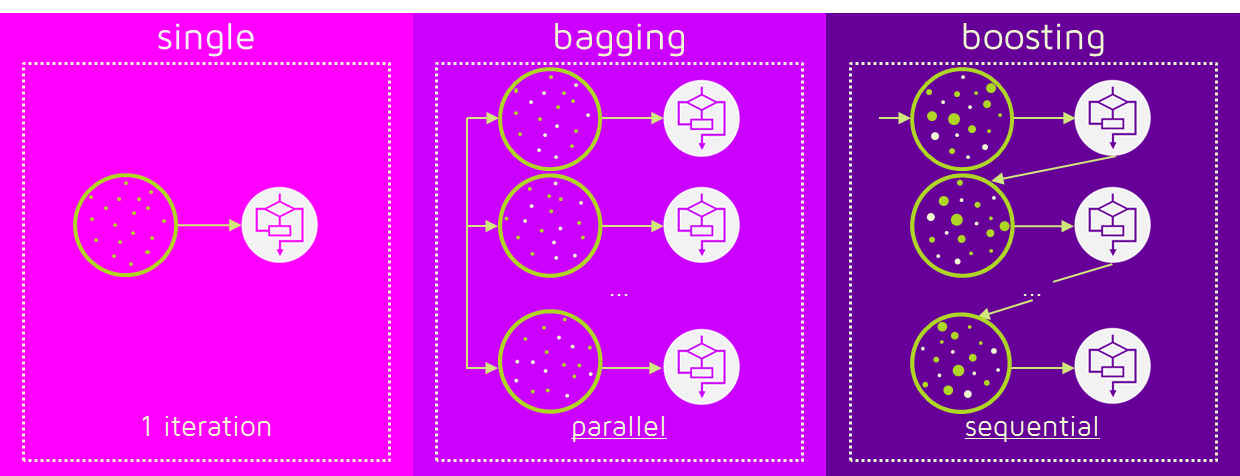

In [1]:
from IPython.display import Image
Image("Image/eee.png")

 - 위에 그림에서 싱글이라고 나온 부분은 앙상블 기법이 아니라 단순히 하나의 모델만으로 결과를 내는 방법이다.
 
 - XGBoost는 부스팅 기법 중 트리 부스팅(Tree Boosting) 기법을 활용한 모델이다.
 
 - 트리 구조를 이용하여 배깅 기법을 사용한 앙상블 모델이 랜덤 포레스트였다면 부스팅 기법을 사용한 앙상블 모델이 XGBoost 이다.
 
 - 최종적으로 XGBoost란 트리 부스팅 방식에 경사 하강법을 통해 최적화하는 방법이다.
 
 - 그리고, 연산량을 줄이기 위해 의사결정 트리를 구성할 때 병렬 처리를 사용해 빠른 시간에 학습이 가능하다.

In [2]:
# 라이브러리
import pandas as pd
import numpy as np
import os
import json
from sklearn.model_selection  import train_test_split


# 데이터 디렉터리 설정
DATA_IN_PATH = "./data_in/"
TRAIN_Q1_DATA_FILE = 'train_q1.npy'
TRAIN_Q2_DATA_FILE = 'train_q2.npy'
TRAIN_LABEL_DATA_FILE = 'train_label.npy'


# Train 데이터 가져오기
train_q1_data = np.load(open(DATA_IN_PATH + TRAIN_Q1_DATA_FILE, 'rb'))
train_q2_data = np.load(open(DATA_IN_PATH + TRAIN_Q2_DATA_FILE, 'rb'))
train_labels = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA_FILE, 'rb'))


# stack 함수를 사용해 두 질문을 하나의 쌍으로 묶는다.
train_input = np.stack((train_q1_data, train_q2_data), axis=1)


# 현재 형태
# [[질문A],[질문B]]
print(train_input.shape)


# 데이터 분리
# 전체 데이터의 20%를 eval 데이터로 분리
train_input, eval_input, train_label, eval_label = train_test_split(train_input, train_labels, test_size=0.2, random_state=4242)


# 모델 입력 데이터 생성
# XGBoost를 사용하려면 입력값을 DMatrix 형태로 만들어야한다.
# 적용과정에서 각 데이터에 대해 sum 함수를 사용하는데, 이는 각 데이터의 두 질문을 하나의 값으로 만들어주기 위해서다.
# 그리고, 두 개의 데이터를 묶어 하나의 리스트로 만든다.
import xgboost as xgb
train_data = xgb.DMatrix(train_input.sum(axis=1), label=train_label) # 학습 데이터 읽어 오기
eval_data = xgb.DMatrix(eval_input.sum(axis=1), label=eval_label) # 평가 데이터 읽어 오기
data_list = [(train_data, 'train'), (eval_data, 'valid')]


# 하이퍼 파라미터 설정
params = {}
params['objective'] = 'binary:logistic'   # 모델의 목적함수 : 로지스틱 회귀
params['eval_metric'] = 'rmse'            # 모델의 평가함수 : RMSE


# 모델 객체 생성
# num_boost_round(데이터 반복 횟수, Epoch) = 10,000
# early_stopping_rounds(조기 머뭄) = 10
# 데이터를 총 10,000번 반복하는데, 만약 10번 동안 에러값이 별로 줄어들지 않으면 학습을 조기에 멈추게 하는 것이다.
bst = xgb.train(params, train_data, num_boost_round = 10000, evals = data_list, early_stopping_rounds=10)

(298526, 2, 31)
[0]	train-rmse:0.483618	valid-rmse:0.484195
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[1]	train-rmse:0.473193	valid-rmse:0.474324
[2]	train-rmse:0.466353	valid-rmse:0.467689
[3]	train-rmse:0.461434	valid-rmse:0.463244
[4]	train-rmse:0.45779	valid-rmse:0.459968
[5]	train-rmse:0.45507	valid-rmse:0.457577
[6]	train-rmse:0.453162	valid-rmse:0.455981
[7]	train-rmse:0.451393	valid-rmse:0.454498
[8]	train-rmse:0.449001	valid-rmse:0.452241
[9]	train-rmse:0.447511	valid-rmse:0.451
[10]	train-rmse:0.446048	valid-rmse:0.449723
[11]	train-rmse:0.445358	valid-rmse:0.449156
[12]	train-rmse:0.444059	valid-rmse:0.448065
[13]	train-rmse:0.44354	valid-rmse:0.447669
[14]	train-rmse:0.44294	valid-rmse:0.447315
[15]	train-rmse:0.44069	valid-rmse:0.445317
[16]	train-rmse:0.439324	valid-rmse:0.444251
[17]	train-rmse:0.438924	valid-rmse:0.443916
[18]	train-rmse:0.438539	valid-rmse:0.443636
[1

[178]	train-rmse:0.402453	valid-rmse:0.425
[179]	train-rmse:0.402396	valid-rmse:0.42499
[180]	train-rmse:0.402192	valid-rmse:0.424956
[181]	train-rmse:0.402073	valid-rmse:0.424935
[182]	train-rmse:0.401897	valid-rmse:0.424862
[183]	train-rmse:0.40185	valid-rmse:0.424845
[184]	train-rmse:0.401829	valid-rmse:0.424832
[185]	train-rmse:0.401769	valid-rmse:0.424821
[186]	train-rmse:0.401515	valid-rmse:0.424791
[187]	train-rmse:0.401184	valid-rmse:0.424689
[188]	train-rmse:0.400875	valid-rmse:0.424589
[189]	train-rmse:0.400644	valid-rmse:0.424507
[190]	train-rmse:0.400584	valid-rmse:0.424483
[191]	train-rmse:0.40048	valid-rmse:0.42444
[192]	train-rmse:0.400416	valid-rmse:0.42441
[193]	train-rmse:0.400349	valid-rmse:0.42438
[194]	train-rmse:0.400329	valid-rmse:0.424369
[195]	train-rmse:0.400096	valid-rmse:0.424336
[196]	train-rmse:0.400004	valid-rmse:0.42431
[197]	train-rmse:0.399962	valid-rmse:0.424304
[198]	train-rmse:0.399677	valid-rmse:0.424187
[199]	train-rmse:0.399359	valid-rmse:0.42398

KeyboardInterrupt: 

In [5]:
train_input.sum(axis=1)

array([[   8,   18,   20, ...,    0,    0,    0],
       [  21, 6863,   36, ...,    0,    0,    0],
       [  11,   41,  322, ...,    0,    0,    0],
       ...,
       [  34,  231, 5507, ...,    0,    0,    0],
       [   4,   22,  170, ...,    0,    0,    0],
       [   8,   18,   10, ...,    0,    0,    0]])

In [6]:
# Test 데이터 불러오기
TEST_Q1_DATA_FILE = 'test_q1.npy'
TEST_Q2_DATA_FILE = 'test_q2.npy'
TEST_ID_DATA_FILE = 'test_id.npy'
test_q1_data = np.load(open(DATA_IN_PATH + TEST_Q1_DATA_FILE, 'rb'))
test_q2_data = np.load(open(DATA_IN_PATH + TEST_Q2_DATA_FILE, 'rb'))
test_id_data = np.load(open(DATA_IN_PATH + TEST_ID_DATA_FILE, 'rb'))

# 모델을 통한 Test 데이터 예측
test_input = np.stack((test_q1_data, test_q2_data), axis=1) 
test_data = xgb.DMatrix(test_input.sum(axis=1))
test_predict = bst.predict(test_data)

In [8]:
# 예측한 결과 저장
DATA_OUT_PATH = "./data_out/"
if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)
    
output = pd.DataFrame({'test_id': test_id_data, 'is_duplicate': test_predict})
output.to_csv(DATA_OUT_PATH + 'simple_xgb.csv', index=False)